# Capstone

## Prepare Notebook

Install pydicom

In [1]:
!pip install pydicom

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable


Mount Google Drive

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

Set Paths

In [5]:
import os

#path = '/content/drive/MyDrive/SIADS_699_Capstone/Capstone_Team_Project' #Google Drive path
path = '/home/ausgear' #Great Lakes
data_path = os.path.join(path, 'data/rsna-pneumonia')
img_path = os.path.join(data_path, 'stage_2_train_images')
obj_path = os.path.join(path, 'python_objects')

In [6]:
os.getcwd()

'/home/ausgear'

## Custom Dataset Class

Definition

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pydicom
from PIL import Image

#Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, indices=None, transform=None, target_transform=None):
        if indices:
            self.img_labels = pd.read_csv(annotations_file).iloc[indices]
        else:
            self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        filename = self.img_labels.iloc[idx, 0] + '.dcm'
        img_path = os.path.join(self.img_dir, filename)
        ds = pydicom.dcmread(img_path)
        img_arr = ds.pixel_array
        image = Image.fromarray(img_arr)
        label = self.img_labels.iloc[idx, -1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return (image, label)

    def get_classes(self):
        return self.img_labels.iloc[:, -1].unique()

    def display_img(self, idx):
        img = self.__getitem__(idx)[0]
        plt.imshow(img, cmap=plt.cm.bone)
        return None

    classes = property(get_classes)

In [8]:
from sklearn.model_selection import train_test_split

annotations_file = os.path.join(data_path, 'stage_2_train_labels.csv')
label_df = pd.read_csv(annotations_file)
display(label_df.head())

X_train, X_val = train_test_split(label_df, test_size=0.2, stratify=label_df['Target'], random_state=42)
X_val, X_test = train_test_split(X_val, test_size=0.5, stratify=X_val['Target'], random_state=42)
X_train, X_val, X_test = X_train.index.tolist(), X_val.index.tolist(), X_test.index.tolist()

print(len(X_train))
print(len(X_val))
print(len(X_test))

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


24181
3023
3023


Initialize

In [9]:
from torchvision import transforms

mean = 0.5
std = 0.5
resize = 256
#Transforms
transforms = dict(
  train = transforms.Compose([
      transforms.Resize(resize),
      transforms.RandomHorizontalFlip(.1),
      transforms.RandomRotation(degrees=(-7, 7)),
      transforms.ToTensor(),
      transforms.Normalize(mean, std),
  ]),
  eval = transforms.Compose([
      transforms.Resize(resize),
      transforms.ToTensor(),
      transforms.Normalize(mean, std),
  ])
)

#Initialize Dataset
train_dataset = CustomImageDataset(annotations_file, img_path, indices=X_train[:5000], transform=transforms['train'])
val_dataset = CustomImageDataset(annotations_file, img_path, indices=X_val, transform=transforms['eval'])
test_dataset = CustomImageDataset(annotations_file, img_path, indices=X_test, transform=transforms['eval'])

## Dataloaders

Initialize

In [10]:
#Dataloader Hyperparameters
batch_size = 16
shuffle = True
pin_memory = False
num_workers = 1

#Initialize Dataloader
train_dataloader = DataLoader(dataset=train_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)
validation_dataloader = DataLoader(dataset=val_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)
test_dataloader = DataLoader(dataset=test_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

print(len(train_dataloader.dataset)//batch_size)

312


Export Dataloader to file

In [11]:
torch.save(train_dataloader, obj_path + '/train_dataloader.pth')
torch.save(validation_dataloader, obj_path + '/validation_dataloader.pth')
torch.save(test_dataloader, obj_path + '/test_dataloader.pth')

In [12]:
#train_reloaded = torch.load(obj_path + '/train_dataloader.pth')

## CNN

Definition

In [13]:
def checkpoint(model, best_loss, epoch, LR, path):
    print('saving')
    state = {
        'model': model,
        'best_loss': best_loss,
        'epoch': epoch,
        'rng_state': torch.get_rng_state(),
        'LR': LR
    }

    torch.save(state, os.path.join(path, 'checkpoint') )

In [14]:
from platform import python_version
print(python_version())
print(torch.__version__)

3.9.7
1.12.1+cu102


In [15]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR

torch.cuda.empty_cache()

feature_extract = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

# Freeze all layers if feature extract
if feature_extract:
    for params in model.parameters():
        params.requires_grad=False

#Adjust first layer to accept input size
model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

#Adjust last couple layers to fit number of classes.
model.classifier[4] = nn.Linear(4096,1024)
model.classifier[6] = nn.Linear(1024,1)

#print(model.classifier)

# If feature extraction, only optimize/update the feautres in the
# classifer layer
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
# Else, we update all features.
else:
    params_to_update = model.parameters()
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

print(model.eval())

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
model = model.to(device)

init_learning_rate = 1e-2

zero, one = label_df.iloc[X_train].Target.value_counts().tolist()
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([zero/one]).to(device))

opt = optim.SGD(model.parameters(), lr=init_learning_rate)
scheduler = StepLR(opt, step_size=5, gamma=0.9)

Using cache found in /home/ausgear/.cache/torch/hub/pytorch_vision_v0.10.0
/home/ausgear/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ausgear/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias
AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

In [16]:
import datetime

best_loss = 1e+8
best_epoch = 0
epochs = 5

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
for epoch in range(epochs):
    model.train()

    total_training_loss = 0
    total_val_loss = 0

    train_correct = 0
    val_correct = 0

    for train_idx, (x, y) in enumerate(train_dataloader):

        if train_idx % 10 == 0:
            print(f'train idx: {train_idx}  time: {datetime.datetime.now().time()}')

        y = y.unsqueeze(1)
        
        x, y = x.to(device), y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred, y.float())

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_training_loss += loss
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    with torch.no_grad():
        model.eval()

        for val_idx, (x, y) in enumerate(validation_dataloader):

            if val_idx % 10 == 0:
                print(f'val idx: {val_idx} time: {datetime.datetime.now().time()}')

            y = y.unsqueeze(1)
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            total_val_loss += loss_fn(pred, y.float())
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
    # break if no val loss improvement in 3 epochs
    if ((epoch - best_epoch) >= 3):
        print("no improvement in 3 epochs, break")
        break

    lr = next(iter(opt.param_groups))['lr']
    
    print('Epoch {} completed - train loss: {:.4f} train correct pred: {:,} val loss {:4f} val correct pred: {:,} LR: {:4f}'.format(
      epoch+1, total_training_loss, train_correct, total_val_loss, val_correct, lr 
          ))

    # checkpoint model if has best val loss yet
    if total_val_loss < best_loss:
        best_loss = total_val_loss
        best_epoch = epoch
        checkpoint(model, best_loss, epoch, lr, obj_path)

    scheduler.step()

train idx: 0  time: 14:48:32.017944
train idx: 10  time: 14:48:33.806213
train idx: 20  time: 14:48:35.603706
train idx: 30  time: 14:48:37.343904
train idx: 40  time: 14:48:39.376104
train idx: 50  time: 14:48:41.122146
train idx: 60  time: 14:48:42.848309
train idx: 70  time: 14:48:44.816690
train idx: 80  time: 14:48:46.616565
train idx: 90  time: 14:48:48.366496
train idx: 100  time: 14:48:50.089371
train idx: 110  time: 14:48:51.821738
train idx: 120  time: 14:48:53.612051
train idx: 130  time: 14:48:55.594326
train idx: 140  time: 14:48:57.310278
train idx: 150  time: 14:48:59.117330
train idx: 160  time: 14:49:00.827706
train idx: 170  time: 14:49:02.541206
train idx: 180  time: 14:49:04.261276
train idx: 190  time: 14:49:06.000749
train idx: 200  time: 14:49:07.771894
train idx: 210  time: 14:49:09.563192
train idx: 220  time: 14:49:11.290862
train idx: 230  time: 14:49:13.007269
train idx: 240  time: 14:49:14.726275
train idx: 250  time: 14:49:16.444228
train idx: 260  time: 1

train idx: 60  time: 14:54:23.893191
train idx: 70  time: 14:54:25.752263
train idx: 80  time: 14:54:27.618422
train idx: 90  time: 14:54:29.269938
train idx: 100  time: 14:54:30.920774
train idx: 110  time: 14:54:32.773570
train idx: 120  time: 14:54:34.622762
train idx: 130  time: 14:54:36.269952
train idx: 140  time: 14:54:37.922475
train idx: 150  time: 14:54:39.582398
train idx: 160  time: 14:54:41.237517
train idx: 170  time: 14:54:43.097587
train idx: 180  time: 14:54:44.948017
train idx: 190  time: 14:54:46.601411
train idx: 200  time: 14:54:48.262810
train idx: 210  time: 14:54:49.917635
train idx: 220  time: 14:54:51.574790
train idx: 230  time: 14:54:53.227981
train idx: 240  time: 14:54:55.081243
train idx: 250  time: 14:54:56.941743
train idx: 260  time: 14:54:59.002285
train idx: 270  time: 14:55:00.665937
train idx: 280  time: 14:55:02.302760
train idx: 290  time: 14:55:03.938572
train idx: 300  time: 14:55:05.592710
train idx: 310  time: 14:55:07.431402
val idx: 0 time:

In [17]:
running_labels = torch.Tensor(0, 1).to(device)
running_outputs = torch.Tensor(0, 1).to(device)

with torch.no_grad():
    model.eval()
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs, labels = inputs.to(device), labels.reshape(-1, 1).float().to(device)

        outputs = model(inputs)

        running_labels = torch.cat((running_labels, labels), dim=0)
        running_outputs = torch.cat((running_outputs, outputs), dim=0)

precision:	0.5887
recall:		0.7853
f1:		0.6729



/tmp/ipykernel_850054/3700865511.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


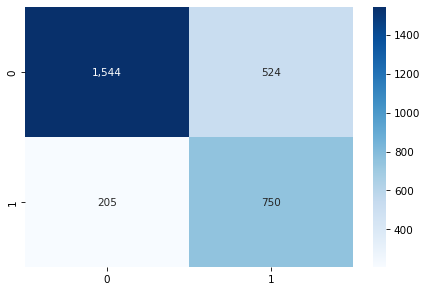

In [18]:
import sklearn.metrics as metrics
import seaborn as sns

y_true = running_labels.cpu().numpy()
y_pred = (running_outputs>=0.0).float().cpu().numpy()
y_proba = torch.nn.Sigmoid()(running_outputs).cpu().numpy()

precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)

print('precision:\t{:.4f}'.format(precision))
print('recall:\t\t{:.4f}'.format(recall))
print('f1:\t\t{:.4f}'.format(f1))
print()

fig = plt.figure(dpi=75)
ax = plt.gca()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True, fmt=',', cmap='Blues')
fig.tight_layout()
fig.show()

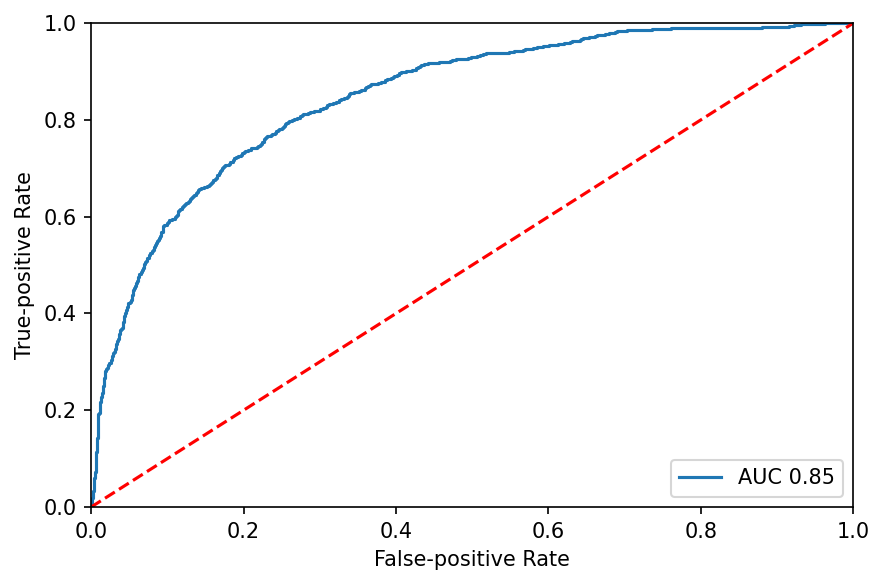

In [19]:
fpr, tpr, _ = metrics.roc_curve(y_true, y_proba)
roc_auc_score = metrics.roc_auc_score(y_true, y_proba)

no_skill = np.linspace(0, 1, 100)

plt.figure(dpi=150)
plt.plot(fpr, tpr, label='AUC {:.2f}'.format(roc_auc_score))
plt.plot(no_skill, no_skill, '--r')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('True-positive Rate')
plt.xlabel('False-positive Rate')
plt.tight_layout()
plt.show()

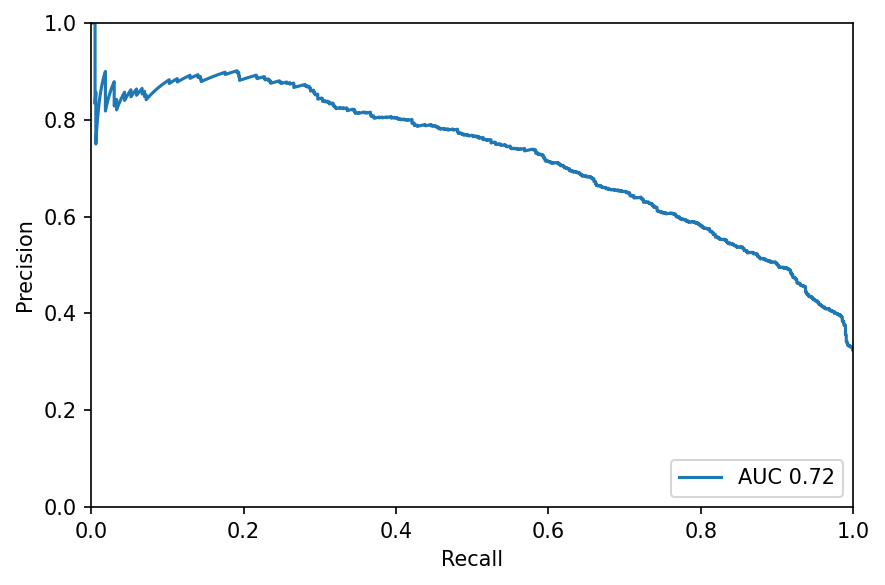

In [20]:
precision, recall, _ = metrics.precision_recall_curve(y_true, y_proba)
auprc_score = metrics.auc(recall, precision)

plt.figure(dpi=150)
plt.plot(recall, precision, label='AUC {:.2f}'.format(auprc_score))
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.tight_layout()
plt.show()